In [95]:
#!conda info

#### Import the required libaries ####

In [96]:
import re
import numpy as np
import pandas as pd
#from nltk.tokenize import word_tokenize
#from nltk.stem import WordNetLemmatizer

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

In [98]:
from sqlalchemy import create_engine

#### Import the data ####

In [99]:
msg_df = pd.read_csv('/data2/home/prasannaiyer/Projects/NLP_Project/Data/disaster_messages.csv')

In [100]:
category_df = pd.read_csv('/home/prasannaiyer/Projects/NLP_Project/Data/disaster_categories.csv')

In [101]:
consol_df = msg_df.merge(category_df, left_on = 'id', right_on = 'id')

#### Question 1: What is the count of messages by genre? ####

In [102]:
msg_genre = pd.Series(data = msg_df['genre'].value_counts().values/msg_df['genre'].value_counts().sum(), \
    index = msg_df['genre'].value_counts().index)
msg_genre = (msg_genre*100).round(0).astype(int)

[Text(0, 0, '13068'), Text(0, 0, '10782'), Text(0, 0, '2398')]

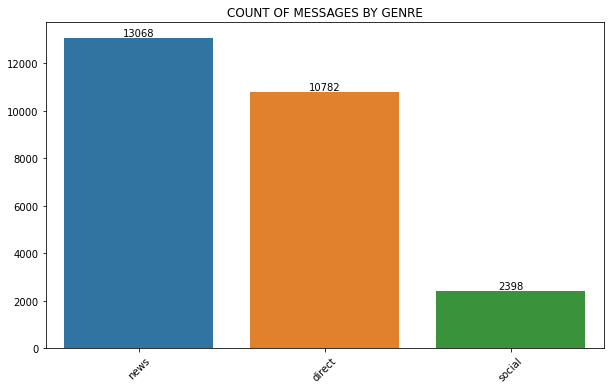

In [103]:
plt.figure(figsize = (10, 6))
ax = sns.barplot(x = msg_df['genre'].value_counts().index, y = msg_df['genre'].value_counts().values)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)
ax.set_title('COUNT OF MESSAGES BY GENRE')
ax.bar_label(ax.containers[0])



#### Split the categories column into individual columns representing each category ####
##### Change column name to reflect each category name ###

In [105]:
categories = consol_df['categories'].str.split(pat = ';', expand = True)

In [107]:
cat_names = categories[0:1].apply(lambda x: x.str[:-2]).astype(str)

In [109]:
categories.columns = cat_names.values.flatten().tolist()

In [67]:
##WIP
#for column in categories.columns:
    #if categories[column].str[-1] not in ['0','1']:
    #print('column name --', column, 'last char -- ',categories[column].str[-1].unique().size)
 #   if categories[column].str[-1].unique().size == 1:
  #      print('column name --', column, 'last char -- ',categories[column].str[-1].unique().size)

column name -- child_alone last char --  1


#### Change the values of each Category to integer type

In [68]:
for column in categories.columns:
    categories[column] = categories[column].str[-1].astype(int)
    categories[column] = categories[column].apply(lambda x: 1 if x > 1 else x)

#### Create new Dataframe with category columns and values

In [70]:
msg_cat_df = pd.concat([consol_df, categories], axis = 1)

In [71]:
msg_cat_df.drop(columns = ['categories'], axis = 1, inplace = True)

#### Remove duplicate data in new Dataframe

In [72]:
msg_cat_clean_df = msg_cat_df.drop_duplicates()

#### Upload Dataframe to a table within SQLite database

In [75]:
engine = create_engine('sqlite:////home/prasannaiyer/Projects/NLP_Project/Data/DisasterResponse.db')

In [27]:
msg_cat_clean_df.to_sql('Message_Category', engine, index=False, if_exists = 'replace')

#### Exploratory data analysis

In [88]:
category_yes = msg_cat_clean_df.loc[:, ~msg_cat_clean_df.columns.isin(['id', 'genre', 'message', 'original'])].sum().values
category_all = msg_cat_clean_df.loc[:, ~msg_cat_clean_df.columns.isin(['id', 'genre', 'message', 'original'])].count().values
category_names = msg_cat_clean_df.columns[~msg_cat_clean_df.columns.isin(['id', 'genre', 'message', 'original'])]
category_summary_dict = {'Category_Name': category_names, 'Total_Yes': category_yes, 'Total_All': category_all}
category_summary = pd.DataFrame(category_summary_dict)

In [90]:
category_summary['Yes_Pct'] = category_summary['Total_Yes']/category_summary['Total_All']

In [124]:
print('These categories ', category_summary[category_summary['Yes_Pct'] < 0.01]['Category_Name'].values.flatten().tolist(), ' have less than 10% YES values')

These categories  ['offer', 'child_alone', 'tools', 'shops']  have less than 10% YES values


In [92]:
category_summary.sort_values(by = 'Total_Yes').style.format(precision = 2, thousands = ',')

,Category_Name,Total_Yes,Total_All,Yes_Pct
9,child_alone,0,"26,215",0.00
2,offer,118,"26,215",0.00
25,shops,120,"26,215",0.00
23,tools,159,"26,215",0.01
31,fire,282,"26,215",0.01
24,hospitals,283,"26,215",0.01
15,missing_people,298,"26,215",0.01
26,aid_centers,309,"26,215",0.01
13,clothing,405,"26,215",0.02
7,security,471,"26,215",0.02


In [94]:
msg_cat_df

,id,message,original,genre,categories
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,related-1;request-0;offer-0;aid_related-0;medi...
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,related-1;request-0;offer-0;aid_related-1;medi...
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,related-1;request-0;offer-0;aid_related-0;medi...
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,related-1;request-1;offer-0;aid_related-1;medi...
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,related-1;request-0;offer-0;aid_related-0;medi...
